In [137]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
lm = LinearRegression()

import statsmodels.api as sm

#Load our two Data Frames
AmesDummies = pd.read_csv('AmesDummies.csv')
AmesDummiesOrdinal = pd.read_csv('AmesDummiesOrdinal.csv')

In [138]:
#Load the RF and XGB features, which contains the list of Features to include in the linear model:
rfFeatures = pd.read_csv('rfFeatures.csv')
xgbFeatures = pd.read_csv('xgbFeatures.csv')

In [139]:
xgbFeatures.head()

,0,1
0,TotalSF,0.087295
1,TotalBsmtSF,0.071737
2,LotArea,0.066984
3,GarageArea,0.044944
4,LotFrontage,0.043215


In [140]:
lst = [rfFeatures, xgbFeatures]
for df in lst:
    df.columns = ['Feature','Score']

In [141]:
rfFeatures.head()

,Feature,Score
0,OverallQual,0.650761
1,TotalSF,0.140105
2,TotalBsmtSF,0.062907
3,BsmtScore,0.022469
4,TotalBath,0.018086


In [129]:
xgbFeatures.head()

,Feature,Score
0,TotalSF,0.087295
1,TotalBsmtSF,0.071737
2,LotArea,0.066984
3,GarageArea,0.044944
4,LotFrontage,0.043215


In [143]:
#Trim AmesDummiesOrdinal to a DF containing only the selected Features:
ames = pd.concat([AmesDummiesOrdinal[list(xgbFeatures['Feature'])], AmesDummiesOrdinal[['SalePrice']]], axis=1)
ames.shape

(1458, 75)

In [144]:
#Transform AmesDF into the Train AmesDF
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size=292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))

ames2 = ames.copy()
ames = ames.iloc[trainIdxes,]
amesTest = ames2.iloc[testIdxes,]

In [145]:
#As we can see, the trimmed DF has 120 total features removed, for a total of 97:
print(AmesDummiesOrdinal.shape)
print(ames.shape)

ames.index = range(1166)

(1458, 187)
(1166, 75)


In [146]:
#Initiate K-fold (n=5) cross-validation model to train/test:

import sklearn.model_selection as ms
ms_k5 = ms.KFold(n_splits=5, shuffle=True)

In [147]:
#Perform separate train/test validation runs for each of the 5 K-fold groups:

#Create X and Y variables
X = ames.drop('SalePrice', axis=1)
Y = ames['SalePrice']

#Rename the true (20% untouched) test DFs
testX = amesTest.drop('SalePrice', axis=1)
testY = amesTest['SalePrice']

#Instantiate the K-fold generator object:
np.random.seed(0)
AmesDF5Fold = ms_k5.split(ames.drop('SalePrice', axis=1), ames['SalePrice'])

#Produce list of test R^2 scores, and Actual vs Predicted lists for the individual runs
R2List = []
PredictList = []
ActualList = []
PureTestR2 = []
RMSLE = []
CoefsDFLinear = pd.DataFrame()

for train, test in AmesDF5Fold:
    
    #Run the fit using the train data for each K
    lm.fit(X.iloc[train,], Y[train])
    #Run your predicion for the "missing" K-part
    p = lm.predict(X.iloc[test,])
    #Check your schore for the missing K-part
    R2 = lm.score(X.iloc[test,], Y[test])
    #Run a test on the completely untouched test 20%
    TestR2 = lm.score(testX, testY)
    
    #Append these scores to the lists above
    R2List.append(R2)
    PureTestR2.append(TestR2)
    PredictList.append(p)
    ActualList.append(Y[test])
    
    #Make predictions for the completely untouched 20%
    PredictionsTest = lm.predict(testX)
    
    #Use these predictions to calculate RMSLE for the untouched 20% and append
    RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(PredictionsTest), 2)))
    RMSLE.append(RMSLEvalue)
    
    #Make a DF of predicted coefficients from each of the five runs
    CoefsDFLinear = pd.concat([CoefsDFLinear, pd.DataFrame({'Linear': pd.Series(lm.coef_)})], axis=1)
    
CoefsDFLinear.index = list(xgbFeatures['Feature'])

In [148]:
CoefsDFLinear.head()

,Linear,Linear,Linear,Linear,Linear
TotalSF,67.854780,64.603031,59.992675,54.562877,55.799761
TotalBsmtSF,26.957640,28.115364,30.751234,27.974693,27.303048
LotArea,0.636898,0.684094,0.579194,0.658654,0.641095
GarageArea,18.710827,3.789451,8.813419,15.558360,21.221892
LotFrontage,173.705636,169.542763,138.800265,123.722421,173.800510


In [149]:
#Export the 5 K-fold-derived sets of linear coefficients to combine with our RF and XGBoost values:
CoefsDFLinear.to_csv('CoefsDFLinear.csv')

In [150]:
#What are the R^2 scores for each of our 5 runs?
print(R2List)
print(PureTestR2)
print(RMSLE)

[0.8576501279084748, 0.8913103611415828, 0.9124917520217178, 0.8566944147159592, 0.8646258585883464]
[0.8734079491971991, 0.8822373418812093, 0.8852104616287539, 0.8853333968483278, 0.8801741986955114]
[0.16023951432077072, 0.16363559916288864, 0.1442506187886454, 0.15200770307381353, 0.15817814070770783]


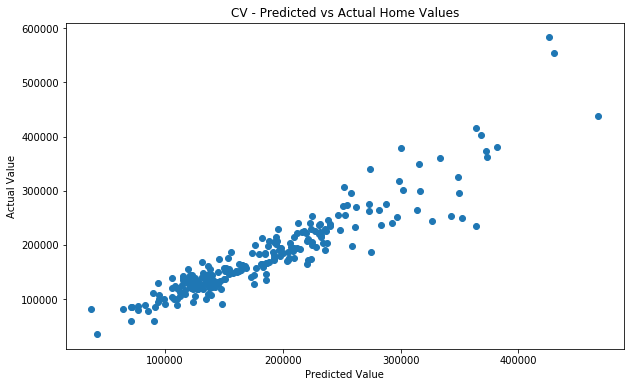

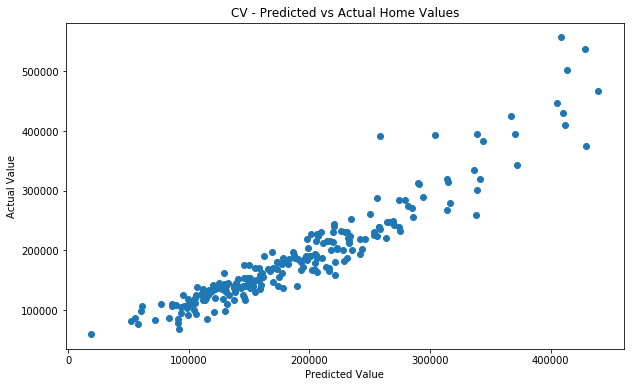

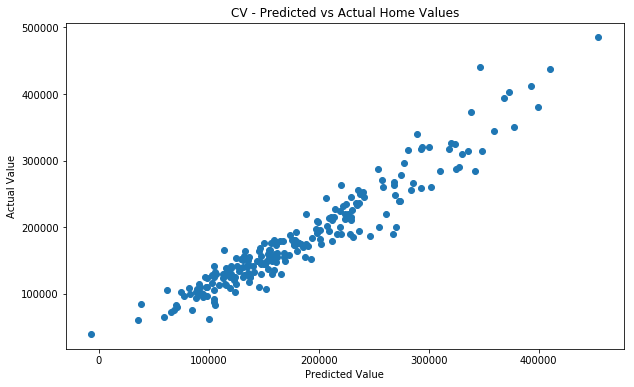

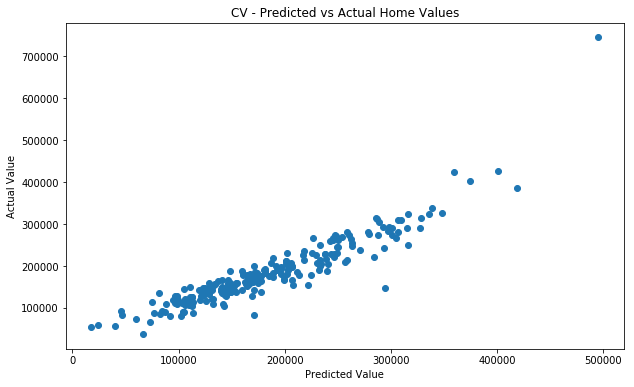

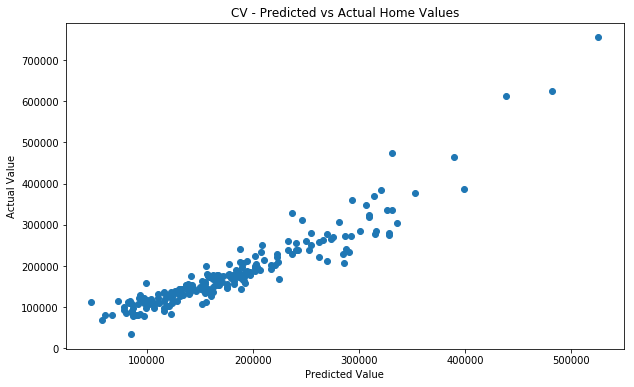

In [151]:
#Plot the predicted vs actual 'SalePrice' values for each of the 5 runs:
import matplotlib.pyplot as plt

for i in range(len(PredictList)):

    plt.figure(figsize=(10,6))
    plt.scatter(PredictList[i], ActualList[i])
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('CV - Predicted vs Actual Home Values')   
    plt.show()

In [152]:
#Just out of curiousity, what would this look like for only 2 folds (50/50 split between groups?)
ms_k2 = ms.KFold(n_splits=2, shuffle=True)

#Perform separate train/test validation runs for each of the 5 K-fold groups:

#Create X and Y variables
X = ames.drop('SalePrice', axis=1)
Y = ames['SalePrice']

testX = amesTest.drop('SalePrice', axis=1)
testY = amesTest['SalePrice']

#Instantiate the K-fold generator object:
np.random.seed(0)
AmesDF2Fold = ms_k2.split(ames.drop('SalePrice', axis=1), ames['SalePrice'])

#Produce list of test R^2 scores, and Actual vs Predicted lists for the individual runs
R2ListN2 = []
PredictListN2 = []
ActualListN2 = []
PureTestR2N2 = []

for train, test in AmesDF2Fold:
    lm.fit(X.iloc[train,], Y[train])
    p = lm.predict(X.iloc[test,])
    R2 = lm.score(X.iloc[test,], Y[test])
    TestR2 = lm.score(testX, testY)
    R2ListN2.append(R2)
    PureTestR2N2.append(TestR2)
    PredictListN2.append(p)
    ActualListN2.append(Y[test])

In [153]:
#What are the R^2 scores for each of our 2 runs? Still a fairly good 79% and 86% R^2 value.
print(R2ListN2)
print(PureTestR2N2)

[0.8296705826012022, 0.8588897024989675]
[0.8083254696492688, 0.8732901783687141]


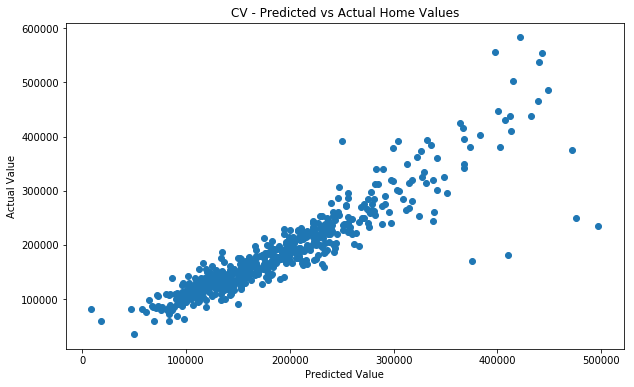

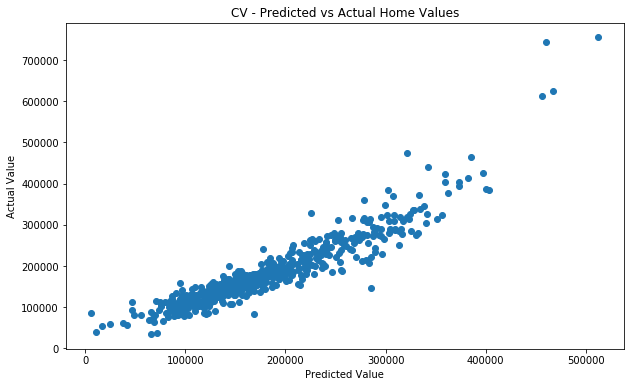

In [154]:
#Let's plot these:
for i in range(len(PredictListN2)):

    plt.figure(figsize=(10,6))
    plt.scatter(PredictListN2[i], ActualListN2[i])
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('CV - Predicted vs Actual Home Values')
    plt.show()

In [155]:
#Trim AmesDummiesOrdinal to a DF containing only the selected Features:
amesRF = pd.concat([AmesDummiesOrdinal[list(rfFeatures['Feature'])],AmesDummiesOrdinal[['SalePrice']]], axis=1)
amesRF.shape

(1458, 29)

In [156]:
#Transform AmesDF into the Train AmesDF
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size=292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))

amesRF2 = amesRF.copy()
amesRF = amesRF.iloc[trainIdxes,]
amesRFTest = amesRF2.iloc[testIdxes,]

In [157]:
#As we can see, the trimmed DF has 120 total features removed, for a total of 67:
print(AmesDummiesOrdinal.shape)
print(amesRF.shape)

amesRF.index = range(1166)

(1458, 187)
(1166, 29)


In [158]:
#Perform separate train/test validation runs for each of the 5 K-fold groups:

#Create X and Y variables
X = amesRF.drop('SalePrice', axis=1)
Y = amesRF['SalePrice']

#Rename the true (20% untouched) test DFs
testX = amesRFTest.drop('SalePrice', axis=1)
testY = amesRFTest['SalePrice']

#Instantiate the K-fold generator object:
np.random.seed(0)
AmesDF5Fold = ms_k5.split(amesRF.drop('SalePrice', axis=1), amesRF['SalePrice'])

#Produce list of test R^2 scores, and Actual vs Predicted lists for the individual runs
R2List = []
PredictList = []
ActualList = []
PureTestR2 = []
RMSLE = []
CoefsDFLinear = pd.DataFrame()

for train, test in AmesDF5Fold:
    
    #Run the fit using the train data for each K
    lm.fit(X.iloc[train,], Y[train])
    #Run your predicion for the "missing" K-part
    p = lm.predict(X.iloc[test,])
    #Check your schore for the missing K-part
    R2 = lm.score(X.iloc[test,], Y[test])
    #Run a test on the completely untouched test 20%
    TestR2 = lm.score(testX, testY)
    
    #Append these scores to the lists above
    R2List.append(R2)
    PureTestR2.append(TestR2)
    PredictList.append(p)
    ActualList.append(Y[test])
    
    #Make predictions for the completely untouched 20%
    PredictionsTest = lm.predict(testX)
    
    #Use these predictions to calculate RMSLE for the untouched 20% and append
    RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(PredictionsTest), 2)))
    RMSLE.append(RMSLEvalue)
    
    #Make a DF of predicted coefficients from each of the five runs
    CoefsDFLinear = pd.concat([CoefsDFLinear, pd.DataFrame({'Linear': pd.Series(lm.coef_)})], axis=1)
    
CoefsDFLinear.index = list(rfFeatures['Feature'])

In [159]:
CoefsDFLinear.head()

,Linear,Linear,Linear,Linear,Linear
OverallQual,9306.066324,11223.205329,10336.248860,10852.092707,9301.157451
TotalSF,71.221409,67.206808,64.779284,57.527107,58.993054
TotalBsmtSF,26.730475,26.152817,31.005117,30.074536,27.893660
BsmtScore,2917.677165,2227.725095,2643.512811,2006.826226,2217.738551
TotalBath,-303.926285,-1558.737407,-1870.949187,-1854.905354,196.047563


In [160]:
#Export the 5 K-fold-derived sets of linear coefficients to combine with our RF and XGBoost values:
CoefsDFLinear.to_csv('CoefsDFLinear2.csv')

In [161]:
#What are the R^2 scores for each of our 5 runs?
print(R2List)
print(PureTestR2)
print(RMSLE)

[0.8361874254615507, 0.8623513149156182, 0.8709082485665165, 0.8303356016166614, 0.8474408100570585]
[0.852548966592177, 0.8617574236000465, 0.8524552875951329, 0.8580422833995519, 0.8612231149615736]
[0.1587925459009047, 0.15760089676189287, 0.1628742613490422, 0.16037895740506497, 0.15193024664662488]


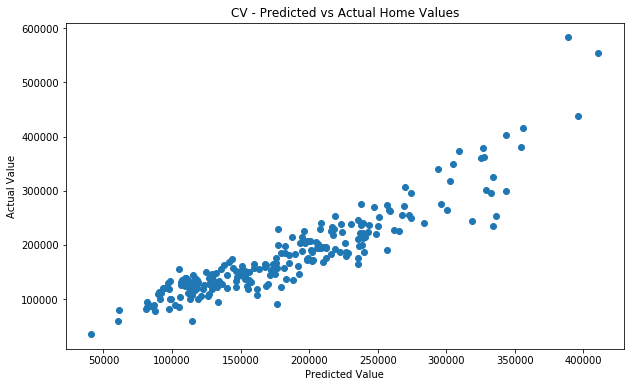

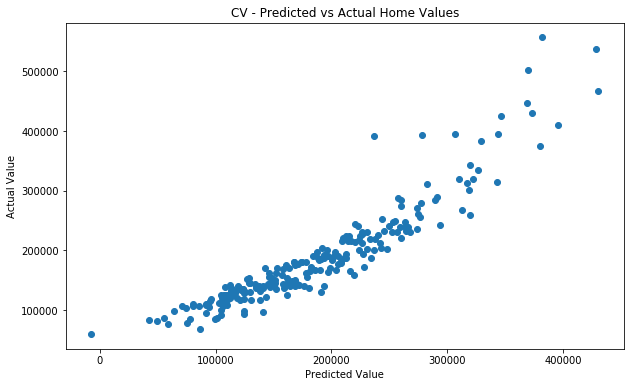

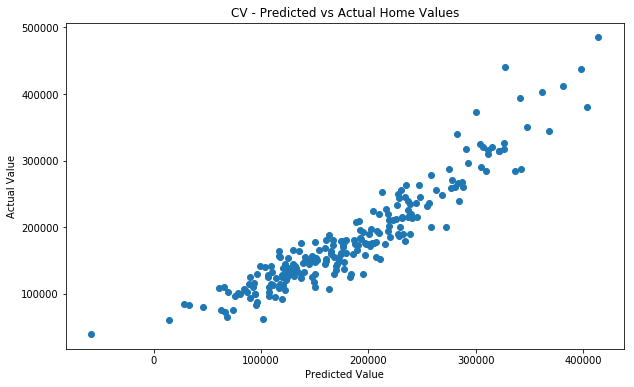

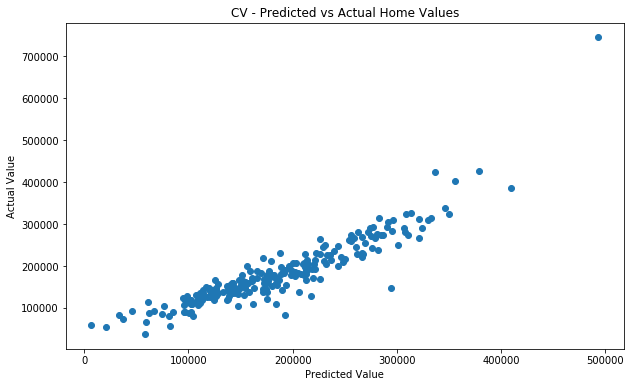

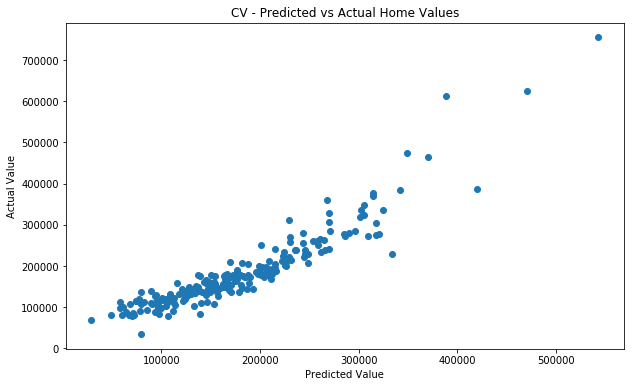

In [162]:
#Plot the predicted vs actual 'SalePrice' values for each of the 5 runs:
import matplotlib.pyplot as plt

for i in range(len(PredictList)):

    plt.figure(figsize=(10,6))
    plt.scatter(PredictList[i], ActualList[i])
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('CV - Predicted vs Actual Home Values')   
    plt.show()

In [163]:
#Just out of curiousity, what would this look like for only 2 folds (50/50 split between groups?)
ms_k2 = ms.KFold(n_splits=2, shuffle=True)

#Perform separate train/test validation runs for each of the 5 K-fold groups:

#Create X and Y variables
X = amesRF.drop('SalePrice', axis=1)
Y = amesRF['SalePrice']

testX = amesRFTest.drop('SalePrice', axis=1)
testY = amesRFTest['SalePrice']

#Instantiate the K-fold generator object:
np.random.seed(0)
AmesDF2Fold = ms_k2.split(amesRF.drop('SalePrice', axis=1), amesRF['SalePrice'])

#Produce list of test R^2 scores, and Actual vs Predicted lists for the individual runs
R2ListN2 = []
PredictListN2 = []
ActualListN2 = []
PureTestR2N2 = []

for train, test in AmesDF2Fold:
    lm.fit(X.iloc[train,], Y[train])
    p = lm.predict(X.iloc[test,])
    R2 = lm.score(X.iloc[test,], Y[test])
    TestR2 = lm.score(testX, testY)
    R2ListN2.append(R2)
    PureTestR2N2.append(TestR2)
    PredictListN2.append(p)
    ActualListN2.append(Y[test])

In [164]:
#What are the R^2 scores for each of our 2 runs? Still a fairly good 79% and 86% R^2 value.
print(R2ListN2)
print(PureTestR2N2)

[0.851127223410828, 0.8420050314567369]
[0.8484851098980072, 0.8575805085794421]


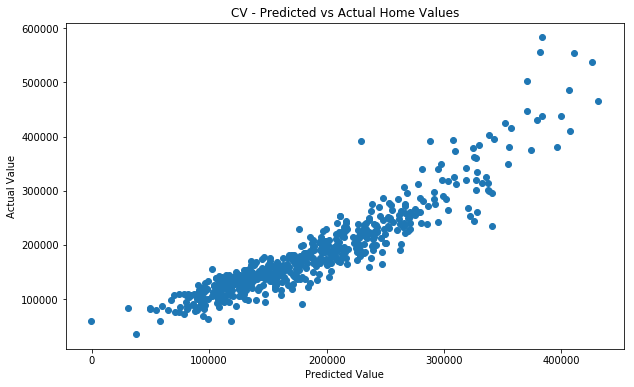

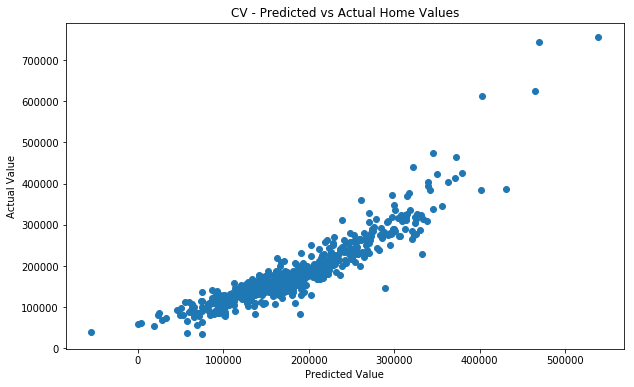

In [165]:
#Let's plot these:
for i in range(len(PredictListN2)):

    plt.figure(figsize=(10,6))
    plt.scatter(PredictListN2[i], ActualListN2[i])
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('CV - Predicted vs Actual Home Values')
    plt.show()